In [11]:
import pickle 
import os
import sys
import pandas as pd
sys.path.append('../topic_model/')
from sampler import BOW_Paragraph_GibbsSampler

In [206]:
def get_pmi(df):
    p_x = df.sum(axis=1).pipe(lambda s: s/s.sum())
    p_y = df.sum(axis=0).pipe(lambda s: s/s.sum())
    p_x_y = df / df.sum().sum()

    output_df = pd.DataFrame(columns=df.columns, index=df.index)

    for x in df.index:
        for y in df.columns:
            output_df.at[x, y] = np.log(p_x_y.loc[x, y]) - np.log(p_x[x]) - np.log(p_y[y])
    
    return output_df

In [231]:
with open('../topic_model/output/trained-sampled-iter-40.pkl', 'rb') as f:
    tm = pickle.load(f)

In [36]:
os.listdir('../topic_model/data/')

['doc_vecs.json', 'vocab.txt']

In [38]:
with open('../topic_model/data/vocab.txt') as f:
    vocab = f.readlines()
    vocab = list(map(lambda x: x.strip(), vocab))

In [40]:
vocab_dict = dict(enumerate(vocab))

In [236]:
word_flat = {}
for doc_id, doc in enumerate(tm.docs[:1000]):
    for par_id, par in enumerate(doc):
        for word_id, word in enumerate(par):
            word_flat[(doc_id, par_id, word_id)] = vocab_dict[word]

In [237]:
word_s = pd.Series(word_flat)

In [232]:
switch_s = pd.Series(tm.switching_variable)

In [238]:
word_and_switch = pd.concat([
    word_s.to_frame('word'), 
    switch_s.to_frame('switch')
], axis=1)

In [239]:
switch_mean = word_and_switch.groupby('word')['switch'].mean()

In [240]:
word_counts = word_s.to_frame('word').assign(c=1).groupby('word')['c'].sum()

In [241]:
switch_mean_and_counts = pd.concat([
    switch_mean.to_frame('mean'),
    word_counts.to_frame('counts')
], axis=1)

In [242]:
switch_mean_and_counts.to_csv('partial_results/mean_and_counts_small.csv')

In [101]:
# switch_mean_and_counts.to_csv('partial_results/mean_and_counts.csv')

In [243]:
import spacy
from tqdm import tqdm_notebook as tqdm

In [244]:
nlp = spacy.load('en_core_web_sm')

In [245]:
pos_tags = {}
for word in tqdm(switch_mean_and_counts.index):
    pos_tags[word] = nlp(word)[0].tag_

In [246]:
pos = {}
for word in tqdm(switch_mean_and_counts.index):
    pos[word] = nlp(word)[0].pos_

In [247]:
switch_mean_and_counts = pd.concat([
    switch_mean_and_counts,
    pd.Series(pos_tags).to_frame('pos_tags'),
    pd.Series(pos).to_frame('pos')
], sort=True, axis=1)

In [256]:
sorted_switch = (switch_mean_and_counts
 .sort_values('mean')
 .loc[lambda df: df['counts']>10]
)

In [257]:
%matplotlib inline
import matplotlib.pyplot as plt

In [258]:
t = pd.concat([
    sorted_switch.iloc[:500].assign(c=1).groupby('pos')['c'].sum().pipe(lambda s: s/s.sum()).to_frame('s=0, 500'),
    sorted_switch.iloc[:1000].assign(c=1).groupby('pos')['c'].sum().pipe(lambda s: s/s.sum()).to_frame('s=0, 1000'),
    sorted_switch.iloc[-1000:].assign(c=1).groupby('pos')['c'].sum().pipe(lambda s: s/s.sum()).to_frame('s=1 1000'),
    sorted_switch.iloc[-500:].assign(c=1).groupby('pos')['c'].sum().pipe(lambda s: s/s.sum()).to_frame('s=1, 500'),
    sorted_switch.assign(c=1).groupby('pos')['c'].sum().to_frame('overall')
], axis=1, sort=True).fillna(0)#.plot(kind='bar')

In [259]:
plt.rc('font', size=18)

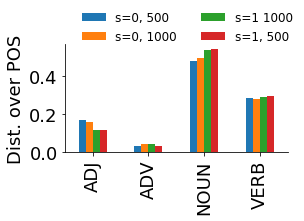

In [368]:
ax = (t.loc[lambda df: df['overall'] > 50]
 .drop('overall', axis=1) #.divide(overall, axis=0)
 .sort_index()
 .dropna()
 .plot(kind='bar', figsize=(4, 2))
)

plt.legend(fontsize=12, ncol=2, bbox_to_anchor=(.57, .5, .5, .9), frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('Dist. over POS')

plt.savefig('../latex/5df51b949f011e000148988d/figures/switching-var.png', bbox_inches='tight')
plt.savefig('../latex/5df51b949f011e000148988d/figures/switching-var.pdf', bbox_inches='tight')

In [262]:
import pyperclip

In [275]:
pyperclip.copy((sorted_switch.assign(mean=lambda df: df['mean'].round(2))
 .pipe(lambda s:
       pd.concat([   
            s.iloc[:10][['mean']].reset_index(),
            s.iloc[-10:][['mean']].sort_values('mean', ascending=False).reset_index()
       ], axis=1)
      )
).to_latex())

# Paragraph type

In [277]:
tm.wordtopic__word_counts

array([12624., 12614., 12643., 12609., 12508., 12274., 12473., 12488.,
       12619., 12441., 12607., 12406., 12693., 12513., 12457., 12597.,
       12482., 12494., 12483., 12404., 12604., 12473., 12487., 12472.,
       12539.])

In [278]:
partype_s = pd.Series(tm.pardoc_to_type)

In [279]:
partype_s.value_counts().to_frame('Par. Type')

,Par. Type
2,2623
0,2301
4,2148
5,1978
6,1931
7,1736
1,1622
8,1545
3,1455
9,1373


In [280]:
partype_by_topic_df = pd.DataFrame(tm.partype_by_wordtopic__wordtopic_counts).T

In [281]:
partype_by_topic_pmi = get_pmi(partype_by_topic_df)

In [282]:
topic_df = pd.DataFrame(tm.vocab_by_wordtopic__word_counts[:-1,:], index=vocab)
topic_df = topic_df/topic_df.sum(axis=0)

In [283]:
import numpy as np 
from scipy.stats import entropy
from IPython.display import HTML

## get top words by topic
top_words_by_topic = []
for i in topic_df.columns:
    sorted_topics = topic_df[i].sort_values(ascending=False).iloc[10:20]
    top_words_by_topic.append(list(sorted_topics.index))

## reformat into an HTML table for easier reading
ncols = 10
table = []
row = []
for topic, words in enumerate(top_words_by_topic):
    subtable_header = '<th>%s</th>' % words[0].upper()
    subtable_body = ''.join(list(map(lambda elem: '<tr><td>%s</td></tr>' % elem, words[1:])))
    subtable = '<table><tr>%s</tr>%s</table>' % (subtable_header, subtable_body)
    row.append(subtable)    
    if (topic % ncols == (ncols - 1)) or (topic == len(top_words_by_topic) - 1) :
        table.append('\n'.join(list(map(lambda elem: '<td>%s</td>' % elem, row))))
        row = []

In [284]:
sorted_topic_df = pd.DataFrame(top_words_by_topic).T
header = sorted_topic_df.loc[0].values
sorted_topic_df = sorted_topic_df.iloc[1:,:]
sorted_topic_df.columns= header

In [285]:
from collections import defaultdict

In [286]:
partype_to_topicwords = defaultdict(list)
for col in partype_by_topic_pmi.columns:
    print(col)
    for topic in (
        # sourcetype_by_topic
        #   .pipe(lambda df: df / df.sum(axis=0))[col]
        partype_by_topic_pmi[col]
            .sort_values(ascending=False)
                .head(3)
                .index
    ):
        
        top_par_topicwords = [sorted_topic_df.columns[topic]] + sorted_topic_df.iloc[:, topic].tolist()[:5]
        partype_to_topicwords[col].append( ', '.join(top_par_topicwords[:3]))
        print(
            '    topic ' + str(topic) + ': ' + 
                ', '.join(top_par_topicwords) + 
                '...'
        )
    print()
    print()
print('...')

0
    topic 14: law, today, million, death, jury, office...
    topic 20: president, trial, crimes, charges, department, according...
    topic 22: law, man, crimes, today, president, public...


1
    topic 11: judge, trial, charges, american, according, white...
    topic 20: president, trial, crimes, charges, department, according...
    topic 5: president, black, judge, prison, jury, department...


2
    topic 4: department, general, trial, law, american, charges...
    topic 18: united, percent, black, street, political, trial...
    topic 13: million, trial, justice, black, work, american...


3
    topic 12: president, states, today, black, death, judge...
    topic 1: cases, evidence, charges, officers, law, public...
    topic 6: office, million, prison, charges, judge, law...


4
    topic 17: charges, department, percent, judge, street, million...
    topic 10: today, public, law, use, told, crimes...
    topic 16: prison, criminal, today, million, charges, general...


5
 

In [287]:
partype_to_topicwords

defaultdict(list,
            {0: ['law, today, million',
              'president, trial, crimes',
              'law, man, crimes'],
             1: ['judge, trial, charges',
              'president, trial, crimes',
              'president, black, judge'],
             2: ['department, general, trial',
              'united, percent, black',
              'million, trial, justice'],
             3: ['president, states, today',
              'cases, evidence, charges',
              'office, million, prison'],
             4: ['charges, department, percent',
              'today, public, law',
              'prison, criminal, today'],
             5: ['president, black, judge',
              'evidence, judge, criminal',
              'president, district, charges'],
             6: ['charges, black, department',
              'prison, criminal, today',
              'president, states, today'],
             7: ['united, percent, black',
              'law, justice, according',
     

In [288]:
def list_to_enumerate(x):
    output = '\n'
    output += '\\makecell{'
    for i in x:
        output += '\n'
        output += i
        output += '\\\\'
    output += '\n'
    output += '}'
    output += '\n'
    return output

In [290]:
pd.options.display.max_colwidth = 200

In [291]:
pyperclip.copy(
    pd.Series(partype_to_topicwords)#[source_cols_to_use]
    .to_latex(escape=False, formatters={0: list_to_enumerate}, header=False)
)

In [324]:
transition_mat = np.zeros((10, 10))

old_partype = list(tm.pardoc_to_type.items())[0][1]
for idx, new_partype in list(tm.pardoc_to_type.items())[1:]:
    if idx[1] != 0:
        transition_mat[old_partype, new_partype] += 1
    old_partype = new_partype

In [302]:
import seaborn as sns

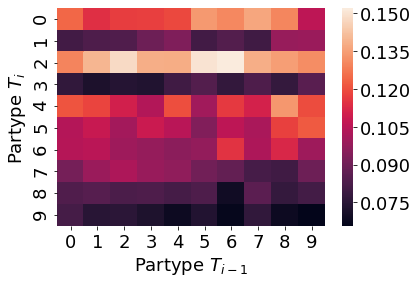

In [333]:
sns.heatmap(transition_mat / transition_mat.sum(axis=1))
plt.xlabel('Partype $T_{i-1}$')
plt.ylabel('Partype $T_{i}$')
plt.savefig('../latex/5df51b949f011e000148988d/figures/transition-matrix.png',bbox_inches='tight')
plt.savefig('../latex/5df51b949f011e000148988d/figures/transition-matrix.pdf', bbox_inches='tight')

In [309]:
import json

In [310]:
with open('results/Kmeans_nested_par_clusters.json') as f:
    word_embeddings = json.load(f)

In [314]:
transition_mat_glove = np.zeros((10, 10))

In [320]:
for doc in word_embeddings:
    for old, new in zip(doc[:-1], doc[1:]):
        transition_mat_glove[old, new] += 1

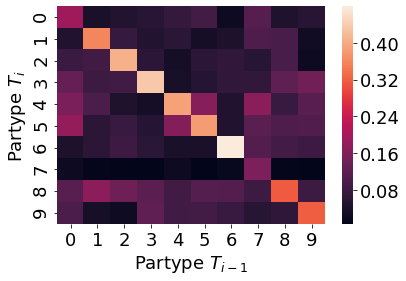

In [332]:
sns.heatmap(transition_mat_glove / transition_mat_glove.sum(axis=1))
plt.xlabel('Partype $T_{i-1}$')
plt.ylabel('Partype $T_{i}$')
plt.savefig('../latex/5df51b949f011e000148988d/figures/transition-matrix-glove.png',bbox_inches='tight')
plt.savefig('../latex/5df51b949f011e000148988d/figures/transition-matrix-glove.pdf', bbox_inches='tight')

In [335]:
first_pars = pd.Series(tm.pardoc_to_type).reset_index().loc[lambda df: df['level_1'] == 0][0]

In [338]:
first_pars_glove = list(map(lambda x: x[0], word_embeddings))

In [339]:
from scipy.stats import entropy

In [351]:
first_pars.value_counts()

2    143
5    126
0    120
4    109
7     98
6     97
3     88
1     84
9     79
8     56
Name: 0, dtype: int64

In [350]:
first_pars.value_counts().pipe(lambda x: x/x.sum()).pipe(lambda s: entropy(s.values))

2.272966944654734

In [349]:
pd.Series(first_pars_glove).value_counts().pipe(lambda x: x/x.sum()).pipe(lambda s: entropy(s.values))

2.222886546247652

# Comparison of First Par-Type

# Check out ICEWS

In [369]:
import pandas as pd

In [370]:
events_df = pd.read_csv('C:/Users/alexa/Downloads/events.2013.20150313084929.tab/events.2013.20150313084929.tab', sep='\t')

In [372]:
events_df.shape

(734989, 20)